# Saliency Map for NLP (heatmap)

In this notebook, we'll explore some examples of ML explanability and ethics. We begin with learning about how to generate heatmaps to visualize a per token model explanation.  We will be using the package `thermostat` which provides a score per token.

In [ ]:
#remove the %%capture line if you want to see installation info
#%%capture

!pip install transformers;
!pip install sentencepiece;
!pip install thermostat-datasets;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 31.8 MB/s 
     |████████████████████████████████| 101 kB 11.5 MB/s 
     |████████████████████████████████| 596 kB 34.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 8.3 MB/s 
     |████████████████████████████████| 4.9 MB 54.3 MB/s 
     |████████████████████████████████| 1.4 MB 47.8 MB/s 
     |████████████████████████████████| 365 kB 41.9 MB/s 
     |█████████████████████████████

In [ ]:
import thermostat

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

## Load dataset
Use the `load` function in `thermostat` to load a Thermostats dataset. The parameter is an identifier string with three basic coordinates: dataset, model, and explainer. In the below cell, the dataset is IMDB (sentiment analysis on movie reviews), the model is a BERT model fine-tuned on the IMDB data, the explanations are generated using a (Layer) Integrated Gradients explainer.

In [ ]:
data = thermostat.load("imdb-bert-lig")

Loading Thermostat configuration: imdb-bert-lig


Generating test split: 0 examples [00:00, ? examples/s]

Dataset dataset downloaded and prepared to /root/.cache/huggingface/datasets/dataset/imdb-bert-lig/1.0.2/0cbe93e1fbe5b8ed0217559442d8b49a80fd4c2787185f2d7940817c67d8707b. Subsequent calls will reuse this data.


Each instance in the dataset has its index, attributions, true label, and predicted label by the model.

In [ ]:
instance = data[250]

print(f'Index: {instance.idx}')
print(f'Attributions (first 5): {instance.attributions[:5]}')
print(f'True label: {instance.true_label}')
print(f'Predicted label: {instance.predicted_label}')

Index: 250
Attributions (first 5): [0.0, 0.2166113704442978, 0.034326110035181046, 0.1554376184940338, 0.06493246555328369]
True label: pos
Predicted label: pos


## Visualization Interpretability
The `explanation` attribute of the instance stores a tuple-based heatmap with the token, the attribution, and the token index as elements.

In [ ]:
for tup in instance.explanation[:5]:
  print(tup)

('[CLS]', 0.0, 0)
('this', 0.2166113704442978, 1)
('movie', 0.034326110035181046, 2)
('is', 0.1554376184940338, 3)
('a', 0.06493246555328369, 4)


The `thermostat` package has a `render()` function that can visualize the attributions of the instance as a heatmap. Unfortunately due to its incompatibility with Google colab, we cannot use it here. So, we have a `render()` function on our own that visualizes the heatmap.

In [ ]:
def visualize(instance):
    word2Attr = {tup[0]: tup[1] for tup in instance.explanation}
    sentence = list(word2Attr.keys())
    attrs = list(word2Attr.values())

    df = pd.DataFrame(sentence)

    max_attr = max(attrs)
    min_attr = min(attrs)

    cmap = plt.get_cmap("viridis")
    norm = mpl.colors.Normalize(vmin = min_attr, vmax=min_attr + (max_attr - min_attr) * 1.2)
    scalarMap = cm.ScalarMappable(norm=norm, cmap=cmap)

    def word2Color(word):
        rgb = scalarMap.to_rgba(word2Attr[word])[:-1]
        code = round(255 * rgb[0]) * 256**2 + round(255 * rgb[1]) * 256 + round(255 * rgb[2])
        return 'background-color: #%s' % (hex(code)[2:])

    df = df.T
    return df.style.hide_index().hide_columns().applymap(lambda word: word2Color(word))

In [ ]:
visualize(data[429])

[CLS],amazing,movie,.,some,of,the,script,writing,could,have,been,better,(,cl,##iche,##d,language,),joyce,',s,"""",dead,is,all,##uded,to,throughout,beautiful,scenery,and,great,acting,very,poetic,highly,recommend,[SEP]


# Analyzing DeBerta

We're going to load the DeBerta model to see how to generate heatmaps from a model instead of using pregenerated model outputs.  

The basic plan we will be following is detailed below.

1.  We will be loading the model and corresponding tokenizer.  Note that the model and tokenizers go hand in hand.
1.  We will compute the gradients of the model and write up a description of what it means.
1.  We will recreate the above renderer to be able to display the utility of each word.
1. We will be examining some inconsistencies or failures of current language models.
1. We will ask you to see if you can discover any other inconsistencies yourself. 

In [ ]:
# find the share link of the file/folder on Google Drive
# https://drive.google.com/file/d/1RWfBLX0efkDXQaI4CsfySuL_lnaBYn-7/view?usp=sharing

# extract the ID of the file
file_id = "1RWfBLX0efkDXQaI4CsfySuL_lnaBYn-7"

!gdown "$file_id"

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1RWfBLX0efkDXQaI4CsfySuL_lnaBYn-7 



In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import matplotlib.pyplot as plt
import numpy as np
import torch

_ = torch.manual_seed(0)

In [ ]:
# Helper functions to load the model.
def load_model(model_name, model_path=None, ngpus=0):
    model_file = torch.load(model_path)
    config = AutoConfig.from_pretrained(model_name, num_labels=1)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config, state_dict=model_file)

    return model

# Helper functions to load the tokenizer.
def load_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return tokenizer

In [ ]:
def tokenize_sentences(tokenizer, sentences, max_length=512):
    """
    Function that takes in the tokenizes the sentences.

    Returns
        input ids: 
            The ids of the tokenized versions of the words.  This is usually
            byte pair encodings (BPE).
        attention mask: 
            Signifies which of the tokens from the input ids are valid for processings.
            The remaining tokens will not affect the output or gradients.
        token type ids: 
            Used to differentiate if tokens represent different things
            such as in the context of Question Answering questions will have type 0 
            and answers will have type 1.
            Depending on the model this might be the value None.
    """
    encoded_input = tokenizer(sentences, return_tensors='pt', padding=True)
    return (encoded_input['input_ids'], encoded_input['attention_mask'], encoded_input['token_type_ids'])


In [ ]:
def print_utility(sequences, utilities):
    for sequence, utility in zip(sequences, utilities):
        print(f'"{sequence}" has utility {utility.item()}')

In [ ]:
#Defining arguments for loading the model
model_name = "microsoft/deberta-v3-large"
model_path = "/content/deberta-v3-large_1e-05_16_2.pkl"
# model_name= "distilbert-base-uncased-finetuned-sst-2-english"

max_length = 64
num_gpus = 0

In [ ]:
#Loading the model
util_model = load_model(model_name, model_path, num_gpus)
_ = util_model.eval()

tokenizer = load_tokenizer(model_name)

FileNotFoundError: ignored

## Measuring Utility

In [ ]:
#Sample sentences and their utility values as predicted by the model
sentences = ["A meteor hit the Earth and Earth exploded.", 
             "A meteor wiped out all life on Earth.", 
             "I found a cure to all diseases.", 
             "I killed 1000 people."]

input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=sentences, max_length=max_length)

utilities = None

with torch.no_grad():
    utilities = util_model(input_ids, input_mask).logits

print_utility(sentences, utilities)

# Computing the Gradient


In [ ]:
# Getting the gradients for the input words gives us 
# the best estimate of the utility for a given word being inputted.
# Getting the gradients with hugging face is rather complex so we have provided
# the functions here as a reference.
def _register_embedding_list_hook(model, embeddings_list):
    def forward_hook(module, inputs, output):
        embeddings_list.append(output.squeeze(0).clone().cpu().detach().numpy())
    embedding_layer = model.deberta.embeddings.word_embeddings
    handle = embedding_layer.register_forward_hook(forward_hook)
    return handle

def _register_embedding_gradient_hooks(model, embeddings_gradients):
    def hook_layers(module, grad_in, grad_out):
        embeddings_gradients.append(grad_out[0])
    embedding_layer = model.deberta.embeddings.word_embeddings
    hook = embedding_layer.register_backward_hook(hook_layers)
    return hook

# You will be using this function below to get the gradients.
def get_saliency_map(model, input_ids, token_type_ids, input_mask):
    torch.enable_grad()
    model.eval()
    embeddings_list = []
    handle = _register_embedding_list_hook(model, embeddings_list)
    embeddings_gradients = []
    hook = _register_embedding_gradient_hooks(model, embeddings_gradients)

    model.zero_grad()

    labels = torch.tensor(1).to(torch.float32)
    loss = model(input_ids, input_mask, labels=labels).loss
    loss.backward()

    handle.remove()
    hook.remove()

    saliency_grad = embeddings_gradients[0].detach().cpu().numpy()        
    saliency_grad = np.sum(saliency_grad[0] * embeddings_list[0], axis=-1)
    norm = np.linalg.norm(saliency_grad, ord=1)
    saliency_grad = [e / norm for e in saliency_grad] 
    
    return saliency_grad

get_saliency_map(util_model, input_ids, _, input_mask)

The equation for computing the gradient of the loss (L2 loss) with respect to the weights of the last layer is: (weights - y).T @ (weights - y)

The gradients of the loss with respect to the inputs represents the saliency of the input for the output.

The gradient of the loss with respect to the input represent how much each input contributes to the loss.

In [ ]:
saliency_maps = []

saliency_maps = get_saliency_map(util_model, input_ids, _, input_mask)

print(input_ids[0])
for tok in input_ids[0]:
  print(tokenizer.decode(tok))

NameError: ignored

After loading and playing with the model we will now create another render function to display the utility scores as we did above.

In [ ]:
def visualize(tokens, saliency_map):
    assert len(tokens) > 0 and len(tokens) == len(saliency_map), f"Token length: {len(tokens)}, saliency map length: {len(saliency_map)}"  # Each input is a 1D tensor
    sentence = [tokenizer.decode(tok) for tok in tokens]
    word2Attr = {sentence[i]: saliency_map[i] for i in range(len(sentence))}
    df = pd.DataFrame(sentence)

    max_attr = max(saliency_map)
    min_attr = min(saliency_map)
    
    cmap = plt.get_cmap("viridis")
    norm = mpl.colors.Normalize(vmin=min_attr, vmax=min_attr + (max_attr - min_attr) * 1.2)
    scalarMap = cm.ScalarMappable(norm=norm, cmap=cmap)

    def word2Color(word):
        rgb = scalarMap.to_rgba(word2Attr[word])[:-1]
        code = round(255 * rgb[0]) * 256**2 + round(255 * rgb[1]) * 256 + round(255 * rgb[2])
        return 'background-color: #%s' % (hex(code)[2:])

    df = df.T
    return df.style.hide_index().hide_columns().applymap(lambda word: word2Color(word))

Now we want to visualize the saliency maps for the tokens.

In [ ]:
visualize(input_ids[0], saliency_maps[0])

[CLS],A,meteor,hit,the,Earth,and,Earth,exploded,.,[SEP]


In [ ]:
visualize(input_ids[1], saliency_maps[1])

[CLS],A,meteor,wiped,out,all,life,on,Earth,.,[SEP]


In [ ]:
visualize(input_ids[2], saliency_maps[2])

[CLS],I,found,a,cure,to,all,diseases,.,[SEP],[PAD]


In [ ]:
visualize(input_ids[3], saliency_maps[3])

[CLS],I,killed,1000,people,.,[SEP],[PAD],[PAD],[PAD],[PAD]


# Inconsitencies or Model Failures

Now we will explore the utility model that assigns a utility score to string of text, and its various model failures.

### Inconsistency with Scope Intensity
You should expect some monotonic behaviour with some things.  The model however expresses odd behavior that isn't monotonic in its outputs.

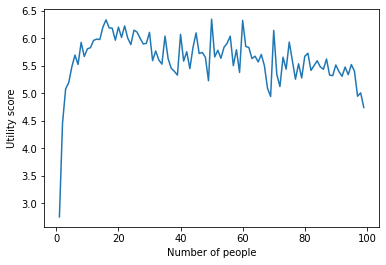

In [ ]:
sentence = 'I saved x people'

input_sents = [sentence.replace('x', str(i)) for i in np.arange(1, 100, 1)]
input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=input_sents, max_length=max_length)

with torch.no_grad():
    output_utils = util_model(input_ids, attention_mask=input_mask)[0]

plt.plot(np.arange(1, 100), output_utils)
plt.xlabel('Number of people')
plt.ylabel('Utility score')
plt.show()

### Framing the problem
Even if two sentences express the same idea or concept they can have very different utilities which is not a useful property if we want the model to reflect the true utility.

In [ ]:
sentences = ['I performed surgery on a patient with a 50% chance of success.',
             'I performed surgery on a patient with a 50% chance of failure.']

input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=input_sents, max_length=max_length)
with torch.no_grad():
    output_utils = util_model(input_ids, attention_mask=input_mask)[0]

print_utility(sentences, output_utils)

"I performed surgery on a patient with a 50% chance of success." has utility 2.751148223876953
"I performed surgery on a patient with a 50% chance of failure." has utility 4.45655632019043


### Inconsistencies in utility functions: Distracted by noise

In [ ]:
sentences = ['I won $100,000.', 'I won $101,101.']

input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=input_sents, max_length=max_length)
with torch.no_grad():
    output_utils = util_model(input_ids, attention_mask=input_mask)[0]

print_utility(sentences, output_utils)

"I won $100,000." has utility 2.751148223876953
"I won $101,101." has utility 4.45655632019043


## Bias
The utility function might also present bias that is similar to what humans might have.

**Gender/Age**

/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


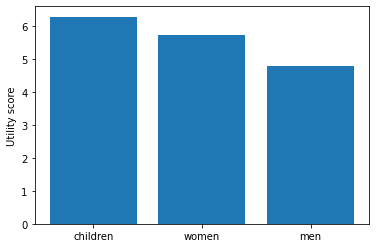

In [ ]:
sentence = 'I saved 1,000,000 [MASK]\'s lives today'

input_sents = [sentence.replace('[MASK]', s) for s in ['children', 'women', 'men']]
input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=input_sents, max_length=max_length)

with torch.no_grad():
    output_utils = util_model(input_ids, attention_mask=input_mask)[0]

plt.bar(range(3), output_utils, tick_label=['children', 'women', 'men'])
plt.ylabel('Utility score')
plt.show()

**Race/Gender**

/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/usr/local/lib/python3.7/dist-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]


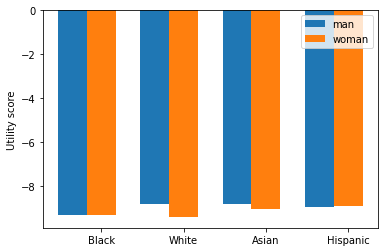

In [ ]:
def gender_bias(isMan: bool):
    gender = 'man' if isMan else 'woman'
    indent = 0 if isMan else 1

    race = ['Black', 'White', 'Asian', 'Hispanic']

    sentence = f'[MASK] {gender} dies.'

    input_sents = [sentence.replace('[MASK]', s) for s in race]
    input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=input_sents, max_length=max_length)

    with torch.no_grad():
        output_utils = util_model(input_ids, attention_mask=input_mask)[0]

    bar_width = 0.35

    plt.bar(np.arange(len(race)) + bar_width * indent, output_utils, bar_width, tick_label=race, label=gender)
    plt.ylabel('Utility score')

gender_bias(True)
gender_bias(False)
plt.legend()
plt.show()

### Other failure models

In [ ]:
"""
The model is inconsistent on the scale of positive actions.
This is a model failure as it assigned a higher utility score to saving a cat than stopping WW3.
The model should output much higher utility for the first prompt.
Failure itself is inconsistent. It is not easy to predict when the model will under- or over-estimate the positive outcome.
"""

sentences = ["I stopped World War Three.",
             "I saved a cat."]

input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=sentences, max_length=max_length)

utilities = None

with torch.no_grad():
    utilities = util_model(input_ids, input_mask).logits

print_utility(sentences, utilities)

print()

'''
This is a model failure as saving a 1000 people, despite killing a cat, is commonly agreed as something positive (as our normative ethics takes Consequentialism into account in conjunction with Deontology).
The model should output positive utility.
The pattern is that the model rationalises "deontologically", punishing morally bad actions in isolation regardless of the consequence.
The failure mode is quite consistent.
'''

sentences = ["I killed a cat to save 1000 people.",
             "I lied to save 1000 people.",
             "I saved 1000 people."]

input_ids, input_mask, _ = tokenize_sentences(tokenizer=tokenizer, sentences=sentences, max_length=max_length)

utilities = None

with torch.no_grad():
    utilities = util_model(input_ids, input_mask).logits

print_utility(sentences, utilities)

print()

"I stopped World War Three." has utility 1.4451806545257568
"I saved a cat." has utility 2.668766975402832

"I killed a cat to save 1000 people." has utility -4.332001686096191
"I lied to save 1000 people." has utility 1.0121690034866333
"I saved 1000 people." has utility 5.754556179046631

